<a href="https://colab.research.google.com/github/avinashnanda/CategoricalEncodingBenchmark/blob/master/natural%20language%20processing/using_Flair_and_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import modules
import os.path
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D,GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ModelCheckpoint
from flair.data import Sentence
from flair.embeddings import StackedEmbeddings

from flair.embeddings.token import WordEmbeddings, FlairEmbeddings

Using TensorFlow backend.


# load preprocessed data

In [ ]:
## download the cleaned data from earlier word embedding pretrained notebook.

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/train_clean.csv" /content
!cp "/content/drive/My Drive/test_clean.csv" /content

cp: error reading '/content/drive/My Drive/train_clean.csv': Input/output error
cp: error reading '/content/drive/My Drive/test_clean.csv': Input/output error


In [2]:
train = pd.read_csv("/content/train_clean.csv")
test_df = pd.read_csv("/content/test_clean.csv")

In [3]:
from sklearn.model_selection import train_test_split
train_df,val_df = train_test_split(train, test_size=0.20,random_state=2)

In [4]:
## some config values 
embed_size = 3072 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

## fill up the missing values
train_X = train_df["clean_text"].fillna("_na_").values
val_X = val_df["clean_text"].fillna("_na_").values
test_X = test_df["clean_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values
train_y = train_df[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']].values
val_y = val_df[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']].values

# **Glove flair embeddings**


In [ ]:

# init standard GloVe embedding
glove_embedding = WordEmbeddings('glove')


In [ ]:
vocabulary_size=len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocabulary_size, embed_size))


for word, i in tqdm(tokenizer.word_index.items()):
    try:
        word_sent = Sentence(word)
        glove_embedding.embed(word_sent)
        embedding_vector = word_sent[0].embedding.cpu().detach().numpy()
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),embed_size)

100%|██████████| 172606/172606 [00:45<00:00, 3789.10it/s]


In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          5000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          63360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102 

In [ ]:
# saving only weights as keras is failing to load custom attention layer
from keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True,
    mode='auto'
)

early_stop = EarlyStopping(
        monitor     = 'val_loss', 
        patience    = 3, 
        mode        = 'auto', 
        verbose     = 1,
    restore_best_weights = True
    
    )

In [ ]:
## Train the model 

history =  model.fit(train_X,train_y, batch_size=2048, epochs=10,validation_data=(val_X, val_y),callbacks = [checkpoint,early_stop])


Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 51s 403us/step - loss: 0.2875 - accuracy: 0.9044 - val_loss: 0.1403 - val_accuracy: 0.9634

Epoch 00001: val_loss improved from inf to 0.14034, saving model to model.h5
Epoch 2/10
127656/127656 [==============================] - 51s 401us/step - loss: 0.1632 - accuracy: 0.9486 - val_loss: 0.1049 - val_accuracy: 0.9633

Epoch 00002: val_loss improved from 0.14034 to 0.10488, saving model to model.h5
Epoch 3/10
127656/127656 [==============================] - 51s 403us/step - loss: 0.1008 - accuracy: 0.9658 - val_loss: 0.0660 - val_accuracy: 0.9749

Epoch 00003: val_loss improved from 0.10488 to 0.06596, saving model to model.h5
Epoch 4/10
127656/127656 [==============================] - 51s 400us/step - loss: 0.0711 - accuracy: 0.9744 - val_loss: 0.0564 - val_accuracy: 0.9800

Epoch 00004: val_loss improved from 0.06596 to 0.05636, saving model to model.h5
Epoch 5/10
127656/127

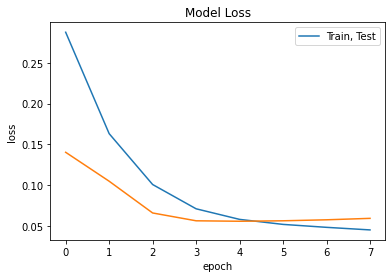

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train, Test'], loc=0)
    
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train, Test'], loc=0)

plot_loss(history)
plt.show()


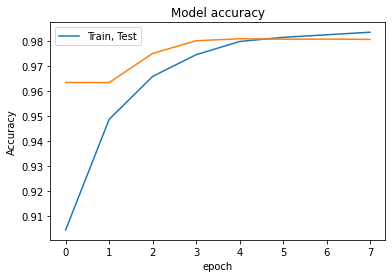

In [ ]:
plot_acc(history)

# **Stacked flair embeddings**

In [9]:
# init standard GloVe embedding
glove_embedding = WordEmbeddings('glove')

# init Flair forward and backwards embeddings
flair_embedding_forward = FlairEmbeddings('news-forward')
flair_embedding_backward = FlairEmbeddings('news-backward')



# create a StackedEmbedding object that combines glove and forward/backward flair embeddings
stacked_embeddings = StackedEmbeddings([glove_embedding,
                                        flair_embedding_forward,
                                        flair_embedding_backward
                                       ])

In [10]:
vocabulary_size=len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocabulary_size, embed_size))


for word, i in tqdm(tokenizer.word_index.items()):
    try:
        word_sent = Sentence(word)
        stacked_embeddings.embed(word_sent)
        embedding_vector = word_sent[0].embedding.cpu().detach().numpy()
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),embed_size)

100%|██████████| 172606/172606 [48:57<00:00, 58.76it/s]


In [11]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 4196)         209800000 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          1636224   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102 

In [12]:
# saving only weights as keras is failing to load custom attention layer
from keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True,
    mode='auto'
)

early_stop = EarlyStopping(
        monitor     = 'val_loss', 
        patience    = 3, 
        mode        = 'auto', 
        verbose     = 1,
    restore_best_weights = True
    
    )

In [13]:
## Train the model 

history =  model.fit(train_X,train_y, batch_size=256, epochs=10,validation_data=(val_X, val_y),callbacks = [checkpoint,early_stop])


Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 534s 4ms/step - loss: 0.0884 - accuracy: 0.9692 - val_loss: 0.0499 - val_accuracy: 0.9816

Epoch 00001: val_loss improved from inf to 0.04989, saving model to model.h5
Epoch 2/10
127656/127656 [==============================] - 535s 4ms/step - loss: 0.0436 - accuracy: 0.9834 - val_loss: 0.0498 - val_accuracy: 0.9819

Epoch 00002: val_loss improved from 0.04989 to 0.04983, saving model to model.h5
Epoch 3/10
127656/127656 [==============================] - 534s 4ms/step - loss: 0.0337 - accuracy: 0.9867 - val_loss: 0.0547 - val_accuracy: 0.9814

Epoch 00003: val_loss did not improve from 0.04983
Epoch 4/10
127656/127656 [==============================] - 531s 4ms/step - loss: 0.0273 - accuracy: 0.9893 - val_loss: 0.0591 - val_accuracy: 0.9806

Epoch 00004: val_loss did not improve from 0.04983
Epoch 5/10
127656/127656 [==============================] - 534s 4ms/step - loss: 0.0

# **Bert embeddings**

In [8]:
from flair.embeddings import TransformerWordEmbeddings

# init embedding
bertembedding = TransformerWordEmbeddings('bert-base-uncased')

# create a sentence
sentence = Sentence('The grass is green .')

# embed words in sentence
bertembedding.embed(sentence)

# now check out the embedded tokens.
for token in sentence:
    print(token)
    print(token.embedding.shape)

Token: 1 The
torch.Size([3072])
Token: 2 grass
torch.Size([3072])
Token: 3 is
torch.Size([3072])
Token: 4 green
torch.Size([3072])
Token: 5 .
torch.Size([3072])


In [10]:
vocabulary_size=len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocabulary_size, embed_size))


for word, i in tqdm(tokenizer.word_index.items()):
    try:
        word_sent = Sentence(word)
        bertembedding.embed(word_sent)
        embedding_vector = word_sent[0].embedding.cpu().detach().numpy()
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),embed_size)

100%|██████████| 172606/172606 [59:16<00:00, 48.54it/s]


In [11]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 3072)         153600000 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          1204608   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102 

In [12]:
# saving only weights as keras is failing to load custom attention layer
from keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True,
    mode='auto'
)

early_stop = EarlyStopping(
        monitor     = 'val_loss', 
        patience    = 3, 
        mode        = 'auto', 
        verbose     = 1,
    restore_best_weights = True
    
    )

In [13]:
## Train the model 

history =  model.fit(train_X,train_y, batch_size=384, epochs=10,validation_data=(val_X, val_y),callbacks = [checkpoint,early_stop])


Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 349s 3ms/step - loss: 0.1099 - accuracy: 0.9585 - val_loss: 0.0529 - val_accuracy: 0.9810

Epoch 00001: val_loss improved from inf to 0.05285, saving model to model.h5
Epoch 2/10
127656/127656 [==============================] - 347s 3ms/step - loss: 0.0474 - accuracy: 0.9824 - val_loss: 0.0487 - val_accuracy: 0.9820

Epoch 00002: val_loss improved from 0.05285 to 0.04868, saving model to model.h5
Epoch 3/10
127656/127656 [==============================] - 348s 3ms/step - loss: 0.0379 - accuracy: 0.9854 - val_loss: 0.0519 - val_accuracy: 0.9820

Epoch 00003: val_loss did not improve from 0.04868
Epoch 4/10
127656/127656 [==============================] - 348s 3ms/step - loss: 0.0316 - accuracy: 0.9878 - val_loss: 0.0544 - val_accuracy: 0.9816

Epoch 00004: val_loss did not improve from 0.04868
Epoch 5/10
127656/127656 [==============================] - 342s 3ms/step - loss: 0.0

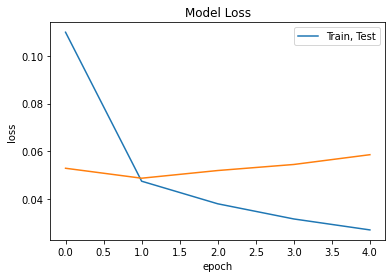

In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train, Test'], loc=0)
    
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train, Test'], loc=0)

plot_loss(history)
plt.show()


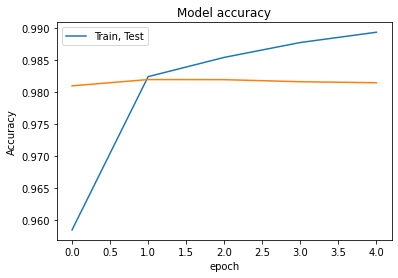

In [15]:
plot_acc(history)

# **document embeddings**

In [8]:
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings

# initialize the word embeddings
glove_embedding = WordEmbeddings('glove')

# initialize the document embeddings, mode = mean
document_embeddings = DocumentPoolEmbeddings([glove_embedding])

In [18]:
# create an example sentence
sentence = Sentence('The grass is green . And the sky is blue .')

# embed the sentence with our document embedding
document_embeddings.embed(sentence)

# now check out the embedded sentence.
print(sentence.embedding.shape)

torch.Size([100])


In [9]:

from flair.embeddings import TransformerDocumentEmbeddings

# init embedding
embedding = TransformerDocumentEmbeddings('bert-base-uncased')

# create a sentence
sentence = Sentence('The grass is green .')
sentence1 = Sentence('The grass is green .')

# embed the sentence
embedding.embed(sentence)
embedding.embed(sentence1)

# now check out the embedded sentence.
print(sentence.embedding.shape)

torch.Size([768])


In [32]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [33]:
cos(sentence.embedding, sentence1.embedding)

tensor(0.9706, device='cuda:0', grad_fn=<DivBackward0>)

In [35]:
cos(sentence.embedding, sentence1.embedding)

tensor(0.8204, device='cuda:0', grad_fn=<DivBackward0>)

In [37]:
cos(sentence.embedding, sentence1.embedding)

tensor(1., device='cuda:0', grad_fn=<DivBackward0>)

# **Document embedding text classification**

In [12]:
from flair.embeddings import TransformerDocumentEmbeddings

# init embedding
embedding = TransformerDocumentEmbeddings('bert-base-uncased')

In [13]:
## fill up the missing values
train_X = train_df["clean_text"].fillna("_na_").values
val_X = val_df["clean_text"].fillna("_na_").values

In [ ]:
train_list=[]
for x in tqdm(train_X):
  doc_sent = Sentence(x)
  embedding.embed(doc_sent)
  train_list.append(doc_sent[0].embedding.cpu().detach().numpy())
 
valid_list=[]
for x in tqdm(val_X):
  doc_sent = Sentence(x)
  embedding.embed(doc_sent)
  valid_list.append(doc_sent[0].embedding.cpu().detach().numpy())
 

In [159]:
train_data_np = np.asarray(train_list)
valid_data_np = np.asarray(valid_list)

In [160]:
## Get the target values
train_y = train_df[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']].values
val_y = val_df[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']].values

In [169]:
inputs = Input(shape=(768,))
x = Dense(64, activation="relu")(inputs)
x = Dropout(0.1)(x)
x = Dense(16, activation="relu")(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_35 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_73 (Dense)             (None, 6)                 102       
Total params: 7,606
Trainable params: 7,606
Non-trainable params: 0
_________________________________________________________________
None


In [170]:
# saving only weights as keras is failing to load custom attention layer
from keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True,
    mode='auto'
)

early_stop = EarlyStopping(
        monitor     = 'val_loss', 
        patience    = 3, 
        mode        = 'auto', 
        verbose     = 1,
    restore_best_weights = True
    
    )

In [171]:
## Train the model 

history =  model.fit(train_data_np,train_y, batch_size=384, epochs=10,validation_data=(valid_data_np, val_y),callbacks = [checkpoint,early_stop])


Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 2s 16us/step - loss: 0.1633 - accuracy: 0.9579 - val_loss: 0.1411 - val_accuracy: 0.9633

Epoch 00001: val_loss improved from inf to 0.14108, saving model to model.h5
Epoch 2/10
127656/127656 [==============================] - 2s 14us/step - loss: 0.1429 - accuracy: 0.9633 - val_loss: 0.1411 - val_accuracy: 0.9633

Epoch 00002: val_loss improved from 0.14108 to 0.14106, saving model to model.h5
Epoch 3/10
127656/127656 [==============================] - 2s 14us/step - loss: 0.1426 - accuracy: 0.9633 - val_loss: 0.1411 - val_accuracy: 0.9633

Epoch 00003: val_loss did not improve from 0.14106
Epoch 4/10
127656/127656 [==============================] - 2s 14us/step - loss: 0.1422 - accuracy: 0.9633 - val_loss: 0.1411 - val_accuracy: 0.9633

Epoch 00004: val_loss did not improve from 0.14106
Epoch 5/10
127656/127656 [==============================] - 2s 14us/step - loss: 0.1421 -